In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random
from typing import List

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
import xgboost as xgb
!pip install catboost
from catboost import CatBoostClassifier, Pool

!pip install optuna
import optuna

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.2 MB/s eta 0:00:00


In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 810
seed_everything(SEED)

In [3]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(
    df: pd.DataFrame,
    year_month: str,
    total_thres: int = TOTAL_THRES,
    print_log: bool = False
):
    df = df.copy()

    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]

    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month

    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()

    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')

    return label

In [4]:
'''
    평가지표를 출력하는 함수
'''
def print_score(label: List[float], pred: List[float], prob_thres: float = 0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

In [5]:
'''
    입력인자로 받는 train, test 데이터에 대해 범주형 피쳐는 레이블 인코딩을
    진행하고 결측치에 대해서는 중위값으로 데이터 전처리를 하는 함수
'''
def feature_preprocessing(
    train: pd.DataFrame,
    test: pd.DataFrame,
    features: list,
    do_imputing=True
):
    x_tr = train.copy()
    x_te = test.copy()

    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))

            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))

            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])

    return x_tr, x_te

In [6]:
def feature_engineering1(df: pd.DataFrame, year_month: str):
    df = df.copy()

    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')

    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]

    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]

    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    all_train_data_list = []  # 여러 데이터프레임을 담을 리스트

    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # 숫자형 컬럼만 선택
        numeric_cols = train.select_dtypes(include=[np.number]).columns
        train_numeric = train.loc[train['order_date'] < tr_ym, numeric_cols]

        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train_numeric.groupby(['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace=True)

        train_agg['year_month'] = tr_ym

        all_train_data_list.append(train_agg)  # 리스트에 데이터프레임 추가

    # 리스트의 데이터프레임들을 하나로 합치기
    all_train_data = pd.concat(all_train_data_list, ignore_index=True)

    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns

    # group by aggretation 함수로 test 데이터 피처 생성
    test_numeric = test[numeric_cols]
    test_agg = test_numeric.groupby(['customer_id']).agg(agg_func)
    test_agg.columns = new_cols

    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)

    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)

    return x_tr, x_te, all_train_data['label'], features


In [7]:
'''
    피처 중요도 정규화(importance_normalized) 및 누적 중요도(cumulative_importance)를 계산하고
    중요도 정규화 순으로 n개의 바플롯을 그리는 함수
'''
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)

    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized',
                            x='feature', color=color,
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel('');
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()

    return df

In [9]:
data = pd.read_csv("/content/drive/MyDrive/1ML/CL_쇼핑데이터/train.csv", parse_dates=["order_date"])
print(data.shape)
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


In [11]:
data.isna().sum()

,0
order_id,0
product_id,0
description,0
quantity,0
order_date,0
price,0
customer_id,0
country,0
total,0


In [12]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,NaN,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,NaN,NaN,NaN,700317,NaN
mean,NaN,NaN,NaN,12.623307,2010-12-26 01:08:30.093324288,6.140931,15313.393466,NaN,33.715373
min,NaN,NaN,NaN,-74215.000000,2009-12-01 07:45:00,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,2010-06-29 11:10:00,2.062500,13963.000000,NaN,7.260000
50%,NaN,NaN,NaN,5.000000,2010-11-28 13:40:00,3.217500,15239.000000,NaN,19.470000
75%,NaN,NaN,NaN,12.000000,2011-07-18 11:55:00,6.187500,16788.000000,NaN,32.175000
max,NaN,NaN,NaN,74215.000000,2011-11-30 17:42:00,64300.500000,18287.000000,NaN,127352.940000


In [13]:
label_2011_11 = generate_label(data, '2011-11')['label']

,count
label,
0,4534
1,1188


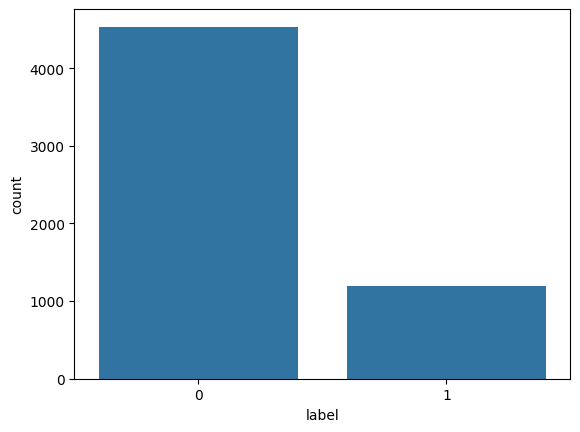

In [14]:
sns.countplot(x='label', data=label_2011_11.to_frame());
label_2011_11.value_counts()

In [28]:
'''
    학습 데이터(train), 테스트 데이터(test)로 LightGBM 모델을
    학습 및 테스트하고 사용된 피처들의 중요도를 반환하는 함수
'''

def make_lgb_prediction(
    train: pd.DataFrame,
    y: pd.Series,
    test: pd.DataFrame,
    features: list,
    categorical_features='auto',
    model_params=None
):
    x_train = train[features]
    x_test = test[features]

    print(x_train.shape, x_test.shape)

    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features

    # LightGBM 데이터셋 선언
    dtrain = lgb.Dataset(x_train, label=y, categorical_feature=categorical_features)

    # LightGBM 모델 훈련
    clf = lgb.train(
        model_params,
        dtrain,
    )

    # 테스트 데이터 예측
    test_preds = clf.predict(x_test)

    # 피처 중요도 저장
    fi['importance'] = clf.feature_importance()

    return test_preds, fi

In [29]:
model_params = {
    'objective': 'binary' # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc' # 평가 지표 설정
    'feature_fraction': 0.8 # 피처 샘플링 비율
    'bagging_fraction': 0.8 # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 100 # 트리 개수
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,
}

In [30]:
train, test, y, features = feature_engineering1(data, '2011-11')
test_preds_2011_11, fi = make_lgb_prediction(train, y, test, features, model_params=model_params)
print_score(label_2011_11, test_preds_2011_11)

categorical feature: []
x_tr.shape (5501, 24) , x_te.shape (5722, 24)
(5501, 21) (5722, 21)
Precision: 0.61644
Recall: 0.22727
F1 Score: 0.33210
ROC AUC Score: 0.76267


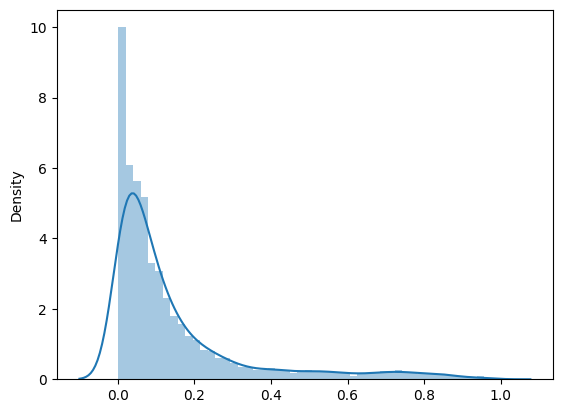

In [23]:
sns.distplot(test_preds_2011_11)
plt.show()

In [24]:
train, test, y, features = feature_engineering1(data, '2011-12')
test_preds, fi = make_lgb_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 24) , x_te.shape (5914, 24)
(5722, 21) (5914, 21)


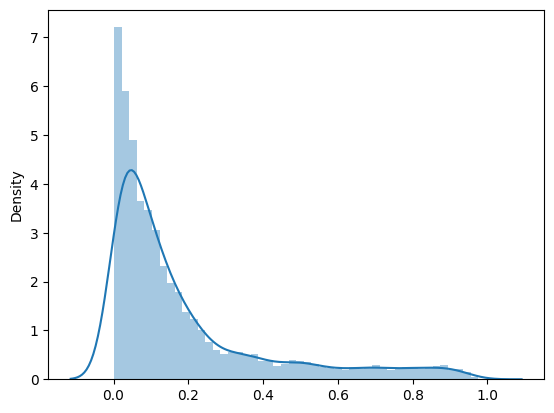

In [25]:
sns.distplot(test_preds)
plt.show()

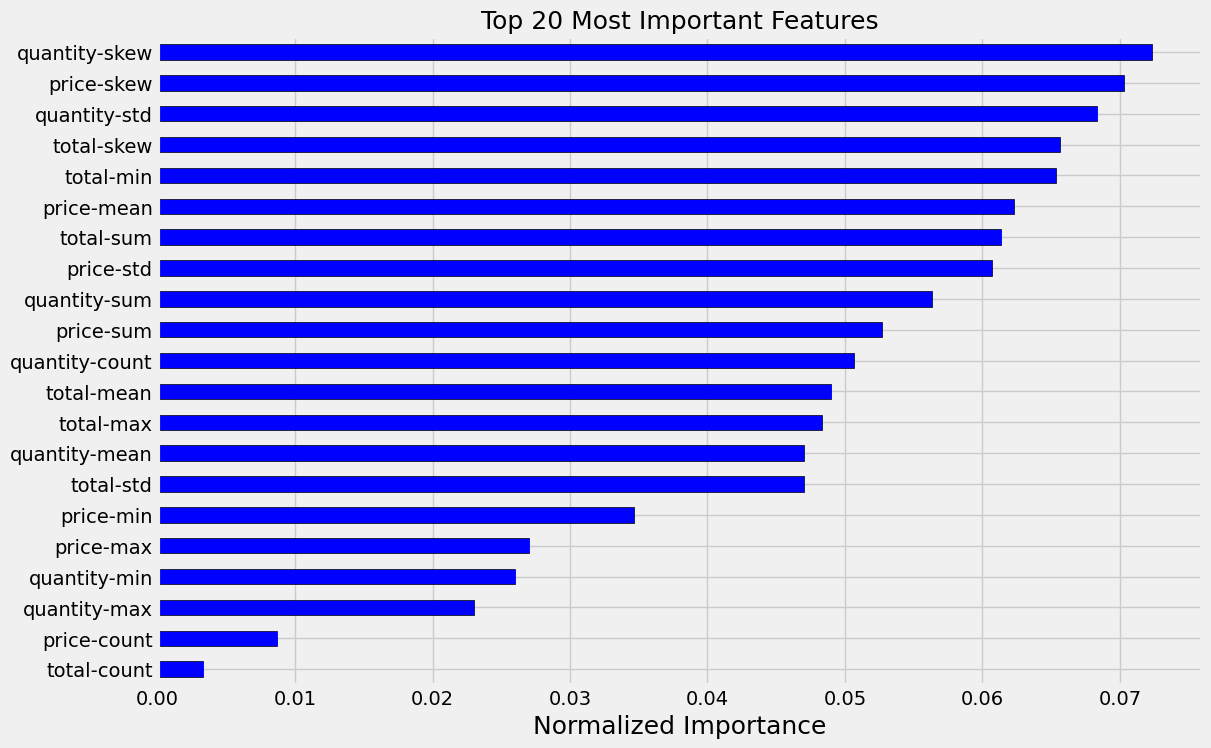

In [26]:
fi = plot_feature_importances(fi)

In [32]:
output_dir = '/content/drive/MyDrive/1ML/CL_쇼핑데이터'
os.makedirs(output_dir, exist_ok=True)

pd.DataFrame(test_preds).to_csv(os.path.join(output_dir, 'output.csv'), index=False)
os.makedirs(output_dir, exist_ok=True)

# submission = pd.read_csv('/content/drive/MyDrive/1ML/CL_쇼핑데이터/sample_submission.csv')
# submission['probability'] = test_preds
# submission.to_csv(os.path.join(output_dir, 'output_lgbm.csv'), index=False)

In [33]:
# 모델비교

In [34]:
'''
    피처 중요도 정규화(importance_normalized) 및 누적 중요도(cumulative_importance)를 계산하고
    중요도 정규화 순으로 n개의 바플롯을 그리는 함수
'''
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)

    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized',
                            x='feature', color=color,
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel('');
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()

    return df

In [38]:
# lgbm K fold cross validation

'''
    학습 데이터(x_tr), 검증 데이터(x_val), 테스트 데이터(test)로 LightGBM 모델을
    학습, 교차(cross) 검증 및 테스트하고 사용된 피처들의 중요도를 반환하는 함수
'''

def make_lgb_oof_prediction(
    train: pd.DataFrame,
    y: pd.Series,
    test: pd.DataFrame,
    features: list,
    categorical_features='auto',
    model_params=None,
    folds: int = 10
):
    x_train = train[features]
    x_test = test[features]

    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])

    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])

    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0

    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features

    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]

        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr, categorical_feature=categorical_features)
        dvalid = lgb.Dataset(x_val, label=y_val, categorical_feature=categorical_features)

        # LightGBM 모델 훈련
        clf = lgb.train(
            params=model_params,
            train_set=dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            callbacks=[lgb.log_evaluation(period=200)]
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)

        # Validation index에 예측값 저장
        y_oof[val_idx] = val_preds

        # 폴드별 Validation 스코어 측정
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds

        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds

        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()

    print(f"\nMean AUC = {score}") # 폴드별 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력

    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)

    return y_oof, test_preds, fi

In [39]:
# lgbm params

model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,
}

In [40]:
train, test, y, features = feature_engineering1(data, '2011-12')
y_oof, test_preds_lgbm, fi = make_lgb_oof_prediction(train, y, test, features, model_params=model_params)

categorical feature: []
x_tr.shape (5722, 24) , x_te.shape (5914, 24)
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7722300373894051
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7726372487320919
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7717091017695812
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.8050287463600388
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7965199324763017
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 6 | AUC: 0.74381805

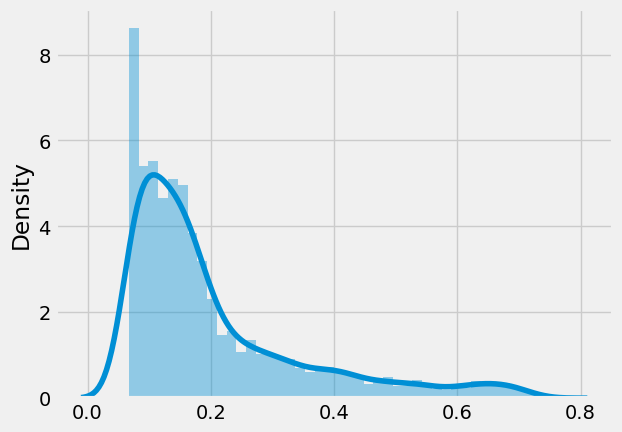

In [41]:
sns.distplot(test_preds_lgbm)
plt.show()

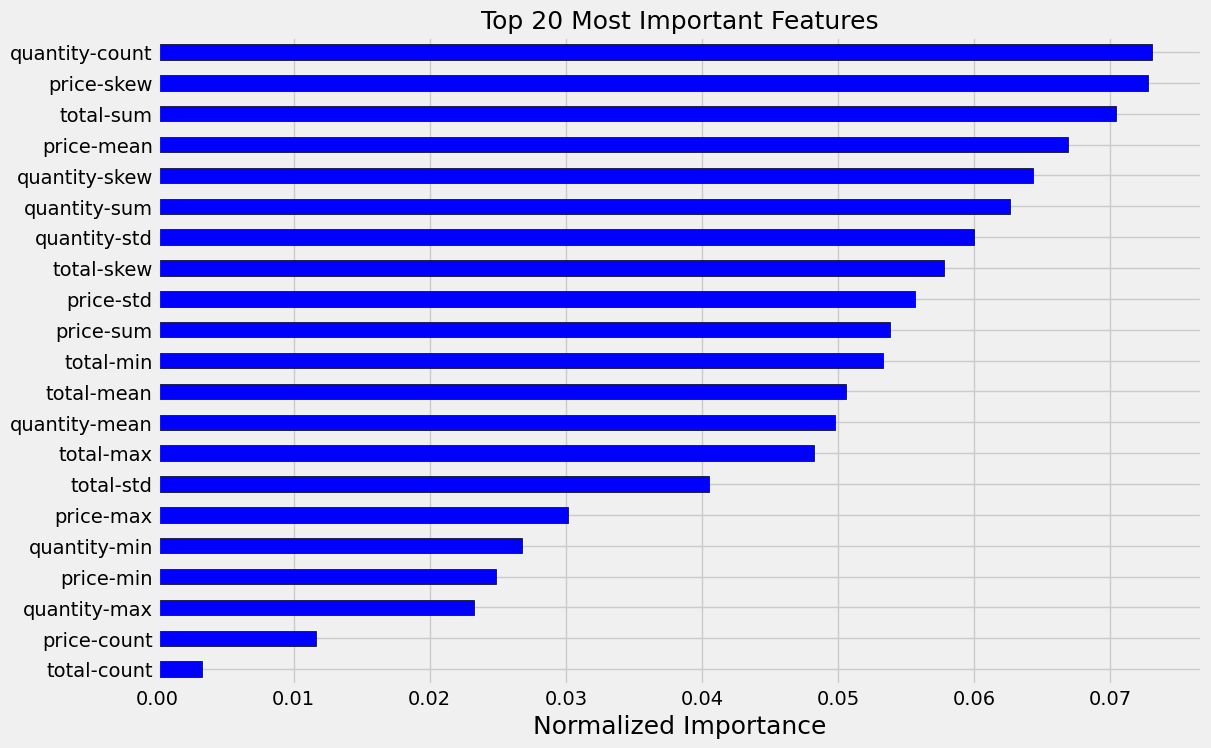

In [42]:
fi = plot_feature_importances(fi)

In [43]:
# 최적의 파라미터 찾기 optuna

'''
    하이퍼파라미터 탐색 범위를 정의하고 튜닝 및 검증을 진행하는 함수
'''

def objective(trial, label=label_2011_11):
    lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # num_leaves 값을 2-256까지 정수값 중에 사용
        'max_bin': trial.suggest_int('max_bin', 128, 256), # max_bin 값을 128-256까지 정수값 중에 사용
        # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
        # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'n_estimators': 10000, # 트리 개수
        'early_stopping_rounds': 100,
        # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'seed': SEED,
        'verbose': -1,
        'n_jobs': -1,
    }

    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds, fi = make_lgb_oof_prediction(train, y, test, features, model_params=lgb_params)

    # Validation 스코어 계산
    val_auc = roc_auc_score(label, y_oof)

    return val_auc

In [44]:
# auc 최대화하는 방향으로 파라미터 탐색

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) # 10회 동안 하이퍼 파라미터 탐색

[I 2025-11-11 03:06:26,086] A new study created in memory with name: no-name-0a05de26-aa53-4145-ad48-6e97e4bc851a


fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7663162181172029
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7521841335653203
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7641211827073844
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7899649070409916
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7916597102417126
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 6 | AUC: 0.731732428070566
--------------------------------------------------------------

[I 2025-11-11 03:06:33,969] Trial 0 finished with value: 0.7700625019493568 and parameters: {'num_leaves': 41, 'max_bin': 142, 'min_data_in_leaf': 26, 'feature_fraction': 0.7481001743870868, 'bagging_fraction': 0.7992133556434788, 'bagging_freq': 3, 'lambda_l1': 2.0130861425873007e-08, 'lambda_l2': 3.0195827645790943e-07}. Best is trial 0 with value: 0.7700625019493568.


Fold 10 | AUC: 0.7973547034707923
--------------------------------------------------------------------------------

Mean AUC = 0.7699768440058163
OOF AUC = 0.7700625019493568
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7573390589716062
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7538407433457965
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7616852086911073
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7760397222429628
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7944237297568034
--------------------------------------------------------

[I 2025-11-11 03:06:40,413] Trial 1 finished with value: 0.7670600283083742 and parameters: {'num_leaves': 153, 'max_bin': 180, 'min_data_in_leaf': 19, 'feature_fraction': 0.4843640806784047, 'bagging_fraction': 0.702151846632565, 'bagging_freq': 6, 'lambda_l1': 0.27798206227467054, 'lambda_l2': 1.049326728933781}. Best is trial 0 with value: 0.7700625019493568.


Fold 10 | AUC: 0.7882464243975736
--------------------------------------------------------------------------------

Mean AUC = 0.7666375562642833
OOF AUC = 0.7670600283083742
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.769000111057639
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7284270536408397
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7650078399163742
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7852049578137833
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7904539299163373
---------------------------------------------------------

[I 2025-11-11 03:06:49,485] Trial 2 finished with value: 0.7638660535660977 and parameters: {'num_leaves': 255, 'max_bin': 239, 'min_data_in_leaf': 33, 'feature_fraction': 0.7627249283546642, 'bagging_fraction': 0.5156086112001381, 'bagging_freq': 3, 'lambda_l1': 0.05668777118232746, 'lambda_l2': 0.0009030676618218277}. Best is trial 0 with value: 0.7700625019493568.


Fold 10 | AUC: 0.7805479807817167
--------------------------------------------------------------------------------

Mean AUC = 0.7638156963931224
OOF AUC = 0.7638660535660977
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7615777588568466
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7400140673009293
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7580265810498021
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7730904203688493
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7859832674791771
--------------------------------------------------------

[I 2025-11-11 03:06:55,729] Trial 3 finished with value: 0.7629869864651514 and parameters: {'num_leaves': 230, 'max_bin': 139, 'min_data_in_leaf': 24, 'feature_fraction': 0.7673706142831211, 'bagging_fraction': 0.49256063363164077, 'bagging_freq': 4, 'lambda_l1': 9.027354015892825e-06, 'lambda_l2': 0.017178447852414905}. Best is trial 0 with value: 0.7700625019493568.



Mean AUC = 0.7639383285439043
OOF AUC = 0.7629869864651514
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7570799244808055
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7587457890645244
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7563652654371686
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7801836780407675
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7868180384736677
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 6 | AUC: 0.7368245311369581
-

[I 2025-11-11 03:07:05,928] Trial 4 finished with value: 0.7641868620033596 and parameters: {'num_leaves': 204, 'max_bin': 190, 'min_data_in_leaf': 32, 'feature_fraction': 0.5545732558694504, 'bagging_fraction': 0.9254386616579723, 'bagging_freq': 2, 'lambda_l1': 3.7769383143660055e-07, 'lambda_l2': 2.361052811233731e-06}. Best is trial 0 with value: 0.7700625019493568.


Fold 10 | AUC: 0.7774315024022853
--------------------------------------------------------------------------------

Mean AUC = 0.7643373970656002
OOF AUC = 0.7641868620033596
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.749537259837856
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7237256135934551
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7330695139251848
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7644291794220861
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7730721427643905
---------------------------------------------------------

[I 2025-11-11 03:07:15,165] Trial 5 finished with value: 0.7500145737629196 and parameters: {'num_leaves': 231, 'max_bin': 196, 'min_data_in_leaf': 15, 'feature_fraction': 0.557789970254023, 'bagging_fraction': 0.46880314463906053, 'bagging_freq': 5, 'lambda_l1': 2.457460267474476e-08, 'lambda_l2': 0.42859724277455763}. Best is trial 0 with value: 0.7700625019493568.


Fold 10 | AUC: 0.7669133878717049
--------------------------------------------------------------------------------

Mean AUC = 0.7507278160170905
OOF AUC = 0.7500145737629196
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7741828008736534
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.758384851738052
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7804076756514596
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7920742178750093
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7854824048824828
---------------------------------------------------------

[I 2025-11-11 03:07:21,165] Trial 6 finished with value: 0.7724483290484614 and parameters: {'num_leaves': 248, 'max_bin': 163, 'min_data_in_leaf': 37, 'feature_fraction': 0.9269504859849252, 'bagging_fraction': 0.6354546518042203, 'bagging_freq': 3, 'lambda_l1': 1.1199209444393072, 'lambda_l2': 2.224658730234561e-06}. Best is trial 6 with value: 0.7724483290484614.


Fold 10 | AUC: 0.7879681673994101
--------------------------------------------------------------------------------

Mean AUC = 0.7725655404375508
OOF AUC = 0.7724483290484614
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7737293155147521
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.773729315514752
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7762077204509819
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.7936795340849698
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.8037360639620086
---------------------------------------------------------

[I 2025-11-11 03:07:27,734] Trial 7 finished with value: 0.777187122660215 and parameters: {'num_leaves': 18, 'max_bin': 157, 'min_data_in_leaf': 39, 'feature_fraction': 0.7372733639241702, 'bagging_fraction': 0.8114984848245969, 'bagging_freq': 4, 'lambda_l1': 0.008783859222046782, 'lambda_l2': 0.9842803304325026}. Best is trial 7 with value: 0.777187122660215.


Fold 10 | AUC: 0.7876249837683418
--------------------------------------------------------------------------------

Mean AUC = 0.7779254357563525
OOF AUC = 0.777187122660215
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7673897752933774
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7637341280124385
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7766557156723661
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.8038527589039051
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7961860240785056
---------------------------------------------------------

[I 2025-11-11 03:07:32,348] Trial 8 finished with value: 0.7764952866408534 and parameters: {'num_leaves': 20, 'max_bin': 213, 'min_data_in_leaf': 30, 'feature_fraction': 0.7417725329863645, 'bagging_fraction': 0.8679921013290557, 'bagging_freq': 2, 'lambda_l1': 0.00011943541382858948, 'lambda_l2': 4.472420683532694e-06}. Best is trial 7 with value: 0.777187122660215.


Fold 10 | AUC: 0.7836830096276921
--------------------------------------------------------------------------------

Mean AUC = 0.7771426096694115
OOF AUC = 0.7764952866408534
fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 1 | AUC: 0.7732388109428794
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
Fold 2 | AUC: 0.7384037315366676
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 3 | AUC: 0.7710557754050624
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 4 | AUC: 0.776021055775405
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
Fold 5 | AUC: 0.7827740367670247
---------------------------------------------------------

[I 2025-11-11 03:07:40,752] Trial 9 finished with value: 0.7644571728162377 and parameters: {'num_leaves': 198, 'max_bin': 196, 'min_data_in_leaf': 29, 'feature_fraction': 0.6541605648608819, 'bagging_fraction': 0.4384358422799678, 'bagging_freq': 3, 'lambda_l1': 3.699525182377609e-07, 'lambda_l2': 3.0309863088066223e-07}. Best is trial 7 with value: 0.777187122660215.


Fold 10 | AUC: 0.7648913870183834
--------------------------------------------------------------------------------

Mean AUC = 0.7637642333572456
OOF AUC = 0.7644571728162377


In [45]:
# validation 스코어 가장 잘나온

study.best_params

{'num_leaves': 18,
 'max_bin': 157,
 'min_data_in_leaf': 39,
 'feature_fraction': 0.7372733639241702,
 'bagging_fraction': 0.8114984848245969,
 'bagging_freq': 4,
 'lambda_l1': 0.008783859222046782,
 'lambda_l2': 0.9842803304325026}

In [46]:
# 성능 가장 잘나온

study.best_value

0.777187122660215

In [47]:
# 하이퍼 파라미터 탐색

study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_max_bin,params_min_data_in_leaf,params_num_leaves,state
0,0,0.770063,2025-11-11 03:06:26.088795,2025-11-11 03:06:33.969861,0 days 00:00:07.881066,0.799213,3,0.748100,2.013086e-08,3.019583e-07,142,26,41,COMPLETE
1,1,0.767060,2025-11-11 03:06:33.970830,2025-11-11 03:06:40.413705,0 days 00:00:06.442875,0.702152,6,0.484364,2.779821e-01,1.049327e+00,180,19,153,COMPLETE
2,2,0.763866,2025-11-11 03:06:40.414739,2025-11-11 03:06:49.485026,0 days 00:00:09.070287,0.515609,3,0.762725,5.668777e-02,9.030677e-04,239,33,255,COMPLETE
3,3,0.762987,2025-11-11 03:06:49.486000,2025-11-11 03:06:55.729173,0 days 00:00:06.243173,0.492561,4,0.767371,9.027354e-06,1.717845e-02,139,24,230,COMPLETE
4,4,0.764187,2025-11-11 03:06:55.731091,2025-11-11 03:07:05.928731,0 days 00:00:10.197640,0.925439,2,0.554573,3.776938e-07,2.361053e-06,190,32,204,COMPLETE
5,5,0.750015,2025-11-11 03:07:05.929747,2025-11-11 03:07:15.165551,0 days 00:00:09.235804,0.468803,5,0.557790,2.457460e-08,4.285972e-01,196,15,231,COMPLETE
6,6,0.772448,2025-11-11 03:07:15.166492,2025-11-11 03:07:21.165607,0 days 00:00:05.999115,0.635455,3,0.926950,1.119921e+00,2.224659e-06,163,37,248,COMPLETE
7,7,0.777187,2025-11-11 03:07:21.166543,2025-11-11 03:07:27.734365,0 days 00:00:06.567822,0.811498,4,0.737273,8.783859e-03,9.842803e-01,157,39,18,COMPLETE
8,8,0.776495,2025-11-11 03:07:27.735315,2025-11-11 03:07:32.348095,0 days 00:00:04.612780,0.867992,2,0.741773,1.194354e-04,4.472421e-06,213,30,20,COMPLETE
9,9,0.764457,2025-11-11 03:07:32.349080,2025-11-11 03:07:40.752083,0 days 00:00:08.403003,0.438436,3,0.654161,3.699525e-07,3.030986e-07,196,29,198,COMPLETE


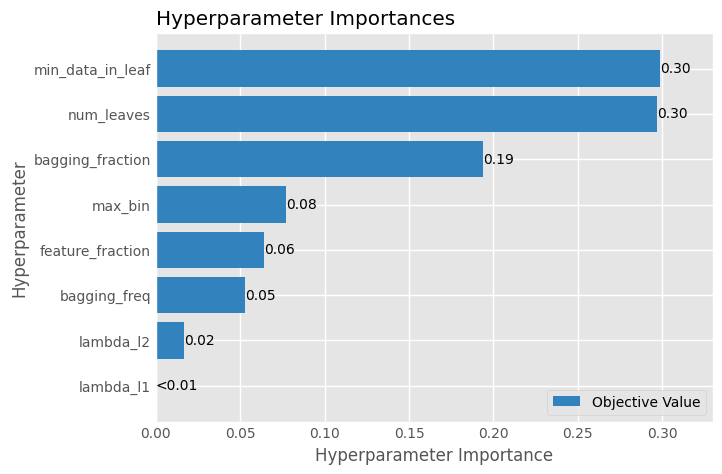

In [48]:
# 파라미터 중요도

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

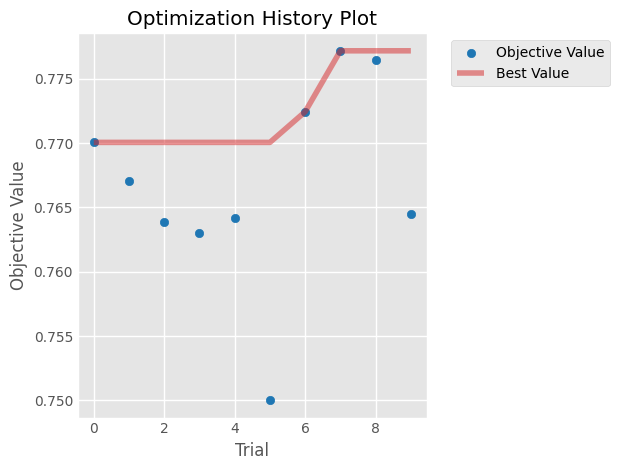

In [49]:
# 파라미터 탐색 히스토리

optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

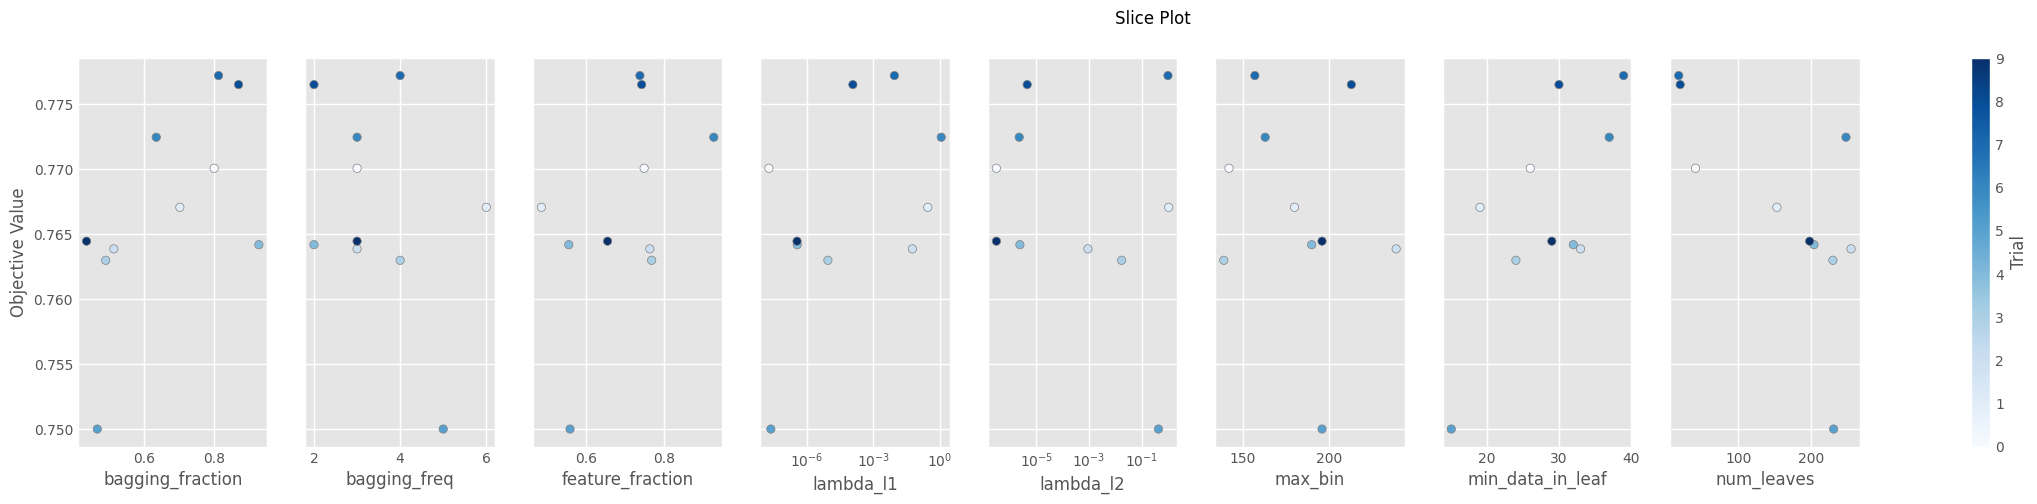

In [50]:
# 파라미터별 스코어 관계

optuna.visualization.matplotlib.plot_slice(study)
plt.show()

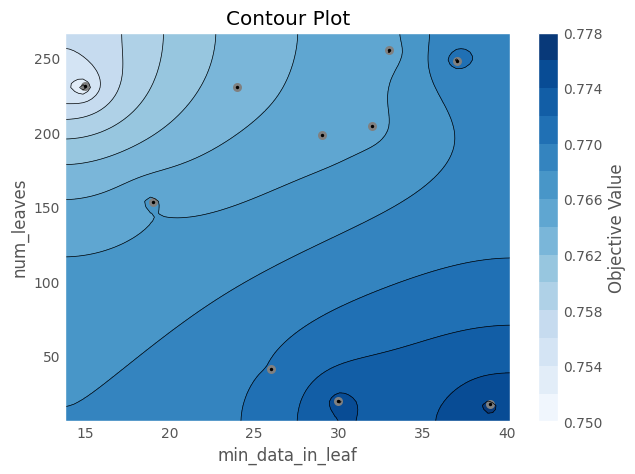

In [51]:
# 파라미터 카운투어

optuna.visualization.matplotlib.plot_contour(study, params=['num_leaves','min_data_in_leaf'])
plt.show()

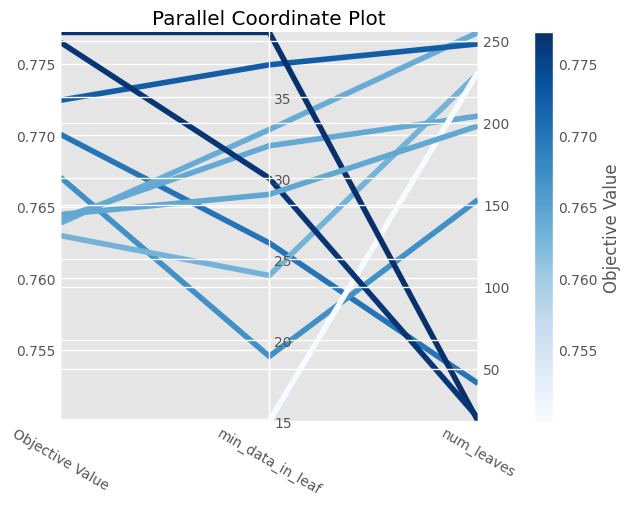

In [52]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['num_leaves','min_data_in_leaf'])
plt.show()

In [53]:
# xgboost K fold cross validation


'''
    학습 데이터(x_tr), 검증 데이터(x_val), 테스트 데이터(test)로 XGBoost 모델을
    학습, 교차(cross) 검증 및 테스트하고 사용된 피처들의 중요도를 반환하는 함수
'''

def make_xgb_oof_prediction(train, y, test, features, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]

    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])

    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])

    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0

    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features

    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]

        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # XGBoost 데이터셋 선언
        dtrain = xgb.DMatrix(x_tr, label=y_tr)
        dvalid = xgb.DMatrix(x_val, label=y_val)

        # XGBoost 모델 훈련
        clf = xgb.train(
            model_params,
            dtrain,
            num_boost_round=10000, # 트리 개수
            evals=[(dtrain, 'train'), (dvalid, 'valid')],  # Validation 성능을 측정할 수 있도록 설정
            verbose_eval=200,
            early_stopping_rounds=100
        )

        # Validation 데이터 예측
        val_preds = clf.predict(dvalid)

        # Validation index에 예측값 저장
        y_oof[val_idx] = val_preds

        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds

        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(xgb.DMatrix(x_test)) / folds

        # 폴드별 피처 중요도 저장
        fi_tmp = pd.DataFrame.from_records([clf.get_score()]).T.reset_index()
        fi_tmp.columns = ['feature',f'fold_{fold+1}']
        fi = pd.merge(fi, fi_tmp, on='feature')

        del x_tr, x_val, y_tr, y_val
        gc.collect()

    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력

    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)

    return y_oof, test_preds, fi

In [54]:
xgb_params = {
    'objective': 'binary:logistic', # 이진 분류
    'learning_rate': 0.1, # 학습률
    'max_depth': 6, # 트리 최고 깊이
    'colsample_bytree': 0.8, # 피처 샘플링 비율
    'subsample': 0.8, # 데이터 샘플링 비율
    'eval_metric': 'auc', # 평가 지표 설정
    'seed': SEED,
}

In [55]:
y_oof, test_preds, fi_xgb = make_xgb_oof_prediction(train, y, test, features, model_params=xgb_params)

fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
[0]	train-auc:0.80648	valid-auc:0.72287
[134]	train-auc:0.99431	valid-auc:0.74414
Fold 1 | AUC: 0.7441417095472549
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
[0]	train-auc:0.81052	valid-auc:0.71731
[123]	train-auc:0.99175	valid-auc:0.73054
Fold 2 | AUC: 0.7305371487802169
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
[0]	train-auc:0.81003	valid-auc:0.73035
[143]	train-auc:0.99552	valid-auc:0.76391
Fold 3 | AUC: 0.7642238482789517
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
[0]	train-auc:0.80311	valid-auc:0.78623
[118]	train-auc:0.99177	valid-auc:0.77081
Fold 4 | AUC: 0.7714291047562158
-------------------------------------------------------------------------

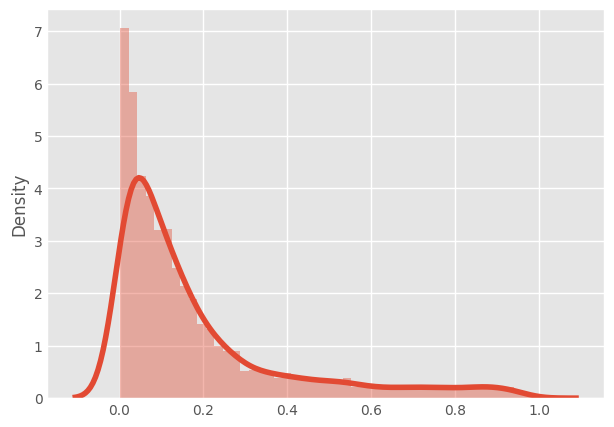

In [56]:
sns.distplot(test_preds)
plt.show()

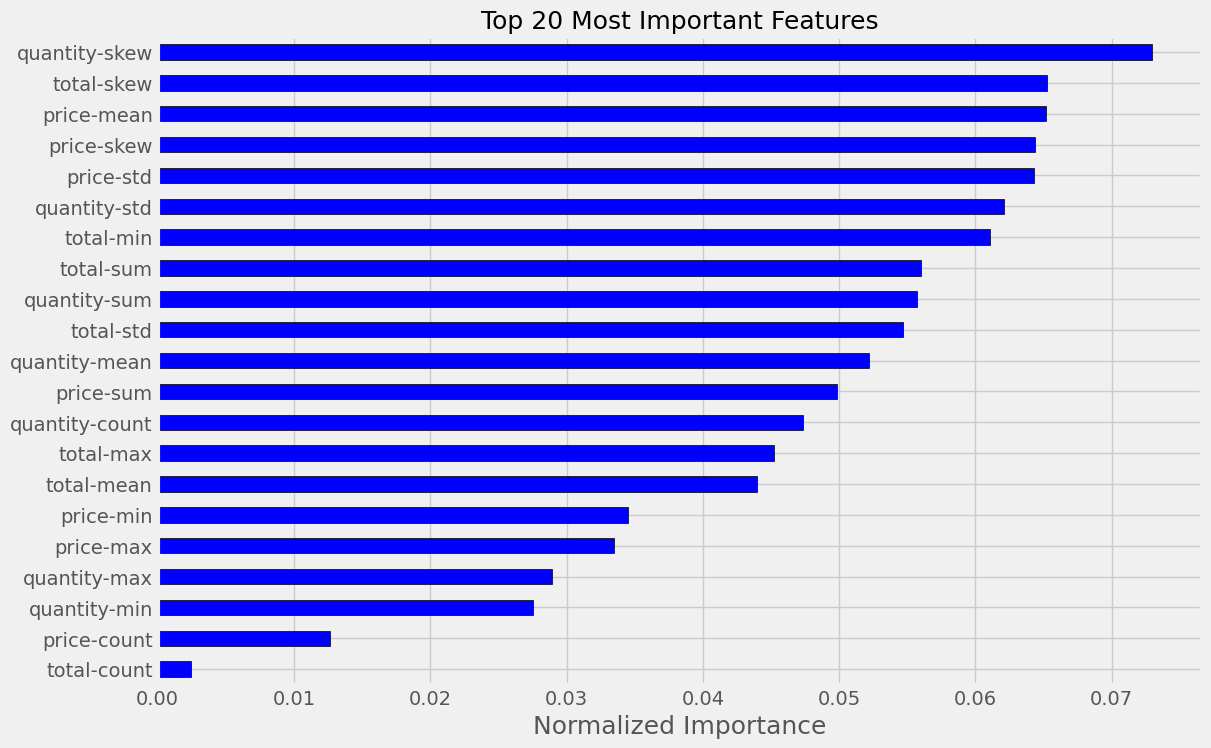

In [57]:
fi_xgb = plot_feature_importances(fi_xgb)

In [58]:
# catboost K fold cross validation

'''
    학습 데이터(x_tr), 검증 데이터(x_val), 테스트 데이터(test)로 CatBoost 모델을
    학습, 교차(cross) 검증 및 테스트하고 사용된 피처들의 중요도를 반환하는 함수
'''

def make_cat_oof_prediction(train, y, test, features, categorical_features=None, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]

    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])

    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])

    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0

    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features

    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]

        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # CatBoost 모델 훈련
        clf = CatBoostClassifier(**model_params)
        clf.fit(x_tr, y_tr,
                eval_set=(x_val, y_val), # Validation 성능을 측정할 수 있도록 설정
                cat_features=categorical_features,
                use_best_model=True,
                verbose=True)

        # Validation 데이터 예측
        val_preds = clf.predict_proba(x_val)[:,1]

        # Validation index에 예측값 저장
        y_oof[val_idx] = val_preds

        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds

        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict_proba(x_test)[:,1] / folds

        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importances_

        del x_tr, x_val, y_tr, y_val
        gc.collect()

    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력

    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)

    return y_oof, test_preds, fi

In [59]:
# catboost params

cat_params = {
    'n_estimators': 10000, # 트리 개수
    'learning_rate': 0.07, # 학습률
    'eval_metric': 'AUC', # 평가 지표 설정
    'loss_function': 'Logloss', # 손실 함수 설정
    'random_seed': SEED,
    'metric_period': 100,
    'od_wait': 100, # early stopping round
    'depth': 6, # 트리 최고 깊이
    'rsm': 0.8, # 피처 샘플링 비율
}

In [60]:
y_oof, test_preds, fi_cat = make_cat_oof_prediction(train, y, test, features, model_params=cat_params)

fold: 1, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
0:	test: 0.7353496	best: 0.7353496 (0)	total: 65.5ms	remaining: 10m 54s


100:	test: 0.7710917	best: 0.7763577 (13)	total: 1.33s	remaining: 2m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7763576796
bestIteration = 13

Shrink model to first 14 iterations.
Fold 1 | AUC: 0.7763576796357309
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 21), x_val.shape: (573, 21)
0:	test: 0.7496298	best: 0.7496298 (0)	total: 15.6ms	remaining: 2m 35s


100:	test: 0.7729056	best: 0.7780421 (4)	total: 838ms	remaining: 1m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7780420538
bestIteration = 4

Shrink model to first 5 iterations.
Fold 2 | AUC: 0.7780420538259356
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7576719	best: 0.7576719 (0)	total: 6.97ms	remaining: 1m 9s


100:	test: 0.7847196	best: 0.7847756 (99)	total: 617ms	remaining: 1m
200:	test: 0.7801650	best: 0.7848690 (102)	total: 1.2s	remaining: 58.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7848689614
bestIteration = 102

Shrink model to first 103 iterations.
Fold 3 | AUC: 0.7848689613977451
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7591372	best: 0.7591372 (0)	total: 6.17ms	remaining: 1m 1s


100:	test: 0.7987381	best: 0.8055887 (5)	total: 589ms	remaining: 57.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8055887404
bestIteration = 5

Shrink model to first 6 iterations.
Fold 4 | AUC: 0.8055887403867692
--------------------------------------------------------------------------------
fold: 5, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7464708	best: 0.7464708 (0)	total: 5.91ms	remaining: 59.1s


100:	test: 0.7894893	best: 0.7914928 (71)	total: 628ms	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.791492756
bestIteration = 71

Shrink model to first 72 iterations.
Fold 5 | AUC: 0.7914927560428144
--------------------------------------------------------------------------------
fold: 6, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.6776764	best: 0.6776764 (0)	total: 6.07ms	remaining: 1m


100:	test: 0.7446899	best: 0.7452464 (98)	total: 597ms	remaining: 58.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7452464429
bestIteration = 98

Shrink model to first 99 iterations.
Fold 6 | AUC: 0.7452464429480402
--------------------------------------------------------------------------------
fold: 7, x_tr.shape: (5150, 21), x_val.shape: (572, 21)


0:	test: 0.7077374	best: 0.7077374 (0)	total: 6.08ms	remaining: 1m
100:	test: 0.7491049	best: 0.7549483 (79)	total: 640ms	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.754948337
bestIteration = 79

Shrink model to first 80 iterations.
Fold 7 | AUC: 0.7549483369506744
--------------------------------------------------------------------------------
fold: 8, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.7974196	best: 0.7974196 (0)	total: 6.09ms	remaining: 1m


100:	test: 0.8195782	best: 0.8265439 (4)	total: 631ms	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8265438626
bestIteration = 4

Shrink model to first 5 iterations.
Fold 8 | AUC: 0.8265438625781438
--------------------------------------------------------------------------------
fold: 9, x_tr.shape: (5150, 21), x_val.shape: (572, 21)
0:	test: 0.6960970	best: 0.6960970 (0)	total: 5.95ms	remaining: 59.4s


100:	test: 0.7650027	best: 0.7719220 (44)	total: 653ms	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7719220138
bestIteration = 44

Shrink model to first 45 iterations.
Fold 9 | AUC: 0.771922013838648
--------------------------------------------------------------------------------
fold: 10, x_tr.shape: (5150, 21), x_val.shape: (572, 21)


0:	test: 0.7472684	best: 0.7472684 (0)	total: 6.21ms	remaining: 1m 2s
100:	test: 0.7888957	best: 0.7957408 (5)	total: 629ms	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7957408129
bestIteration = 5

Shrink model to first 6 iterations.
Fold 10 | AUC: 0.795740812881444
--------------------------------------------------------------------------------

Mean AUC = 0.7830751660485946
OOF AUC = 0.7320275798716469


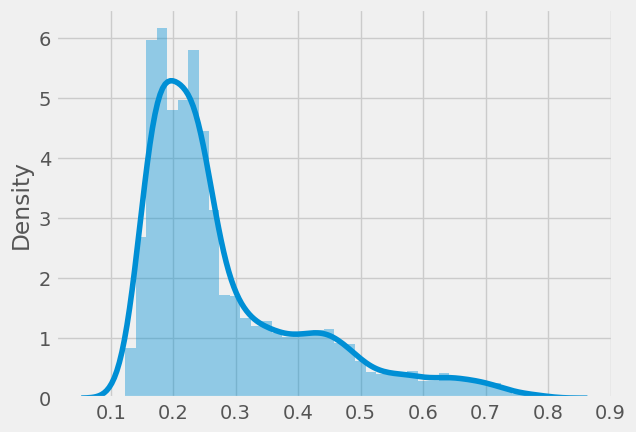

In [61]:
sns.distplot(test_preds)
plt.show()

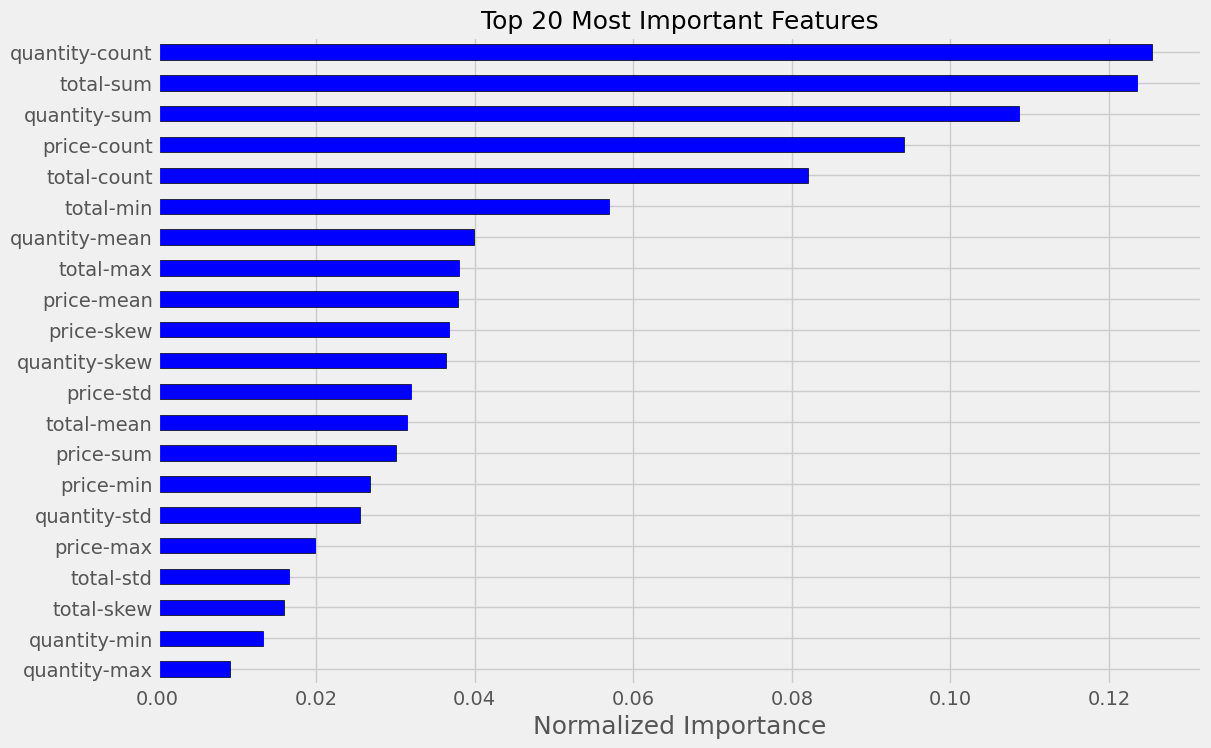

In [62]:
fi_cat = plot_feature_importances(fi_cat)